# Identifying Risk Profiles by Exploitation Type in North America

## Project Overview - The CDTC Global Synthetic Dataset

### Introduction
I wanted to approach a gravitational, social science based problem for this analysis. My motivation in working with this specific dataset is the goal of identifying critical risk factors in vulnerable populations across North America (Mexico, The United States, and Canada). If contexts in which a certain population experiences increased vulnerability to trafficking are identified, this awareness could inform policy and increase public awareness.  

Working with human trafficking data requires more than technological prowess, but sensitivity to the biases embedded in the data and in the analyst themselves. Before beginning this analysis, I would like to start by discussing how the data is collected and addressing biases before delving into the analysis.

### The Data and Limitations:
This data contains "critical information on the socio-demographic profile of victims, types of exploitation, and the trafficking process, including means of control used". Containing "over 222,000 victims and survivors of trafficking identified across 197 countries and territories from 2002 to 2023". It is a synthetic dataset, meant to illustrate patterns rather than exact real-world prevalence.

Now I will identify biases and justify some analytical decisions made later on. This is not a complete list of the biases inherent in tasks like this, however it is the three that I found to be most domineering in the literature. I chose to identify biases first, because I feel that these should already be identified when discussing analytical results. 


#### Biases: 
* Population Bias: 
    * Due to the global nature of this dataset, it is important to follow previous literature in the field's understanding of how different cultures view exploitation differently. Because of this, I have restricted my analysis to the countries of North America in order to most closly align the notion of exploitation with my own. However, that does not mean this bias is eradicated, merely mitigated. 

* Behavioral Bias:
    * This data is self reported, meaning there is an inescapable bias to its presentation. Certain demographics represented may be more or less likely to report their situations. 

* Sampling Bias: 
    * This form of bias is identified by the CTDC themselves. Due to the collection mechanisms of the data, it only becomes available to the CTDC when reported by partnering organizations. Therefore, it is not a population representative sample. This does not negate its importance.

### Background
The two papers I am using to guide my analysis are:

* Weitzer, R. (2014). New Directions in Research on Human Trafficking. The ANNALS of the American Academy of Political and Social Science, 653(1), 6-24. 
    * [In this paper](https://doi.org/10.1177/0002716214521562P), Weitzer identifies the flaws in making sweeping claims about human trafficking data across continents and countries. This paper encouraged me to restrict my analysis to North America, while acknowledging that "the data featured in the global victim of trafficking dataset come from the assistance activities of the contributing organizations, including case management services and counter-trafficking hotline logs." This means all victims were either enrolled in assistance services OR able to contact a hot-line. This is a subset of all human trafficking victims. 

* Reid, J. A. (2012). Exploratory review of route-specific, gendered, and age-graded dynamics of exploitation: Applying life course theory to victimization in sex trafficking in North America. Aggression and Violent Behavior, 17(3), 257–271.
    * [This paper](https://doi.org/10.1016/j.avb.2012.02.005) looks at three distinct variables in human trafficking across North America: international vs domestic, male vs female, child vs adult. Here Reid finds "route-specific" vulnerabilities. In other words, differences between trafficking patterns in internationally vs domestically trafficked victims across North America. Here, I will extend this analysis to identify if these patterns are consistent across exploitation types in the CTDC data set. 

### Research Question: 
* What features in the CTDC predict exploitation type in North America? 
* Hypothesis: Victim demographics, control methods, and recruiter relationships will differ between sexual and labour exploitation. 

### Methodology:
I will use logistic regression to create 2 distinct models predicting whether or not a given case will be identified as an instance of sexual or labour exploitation. Because these forms of exploitation are not mutually exclusive (meaning one can experience both), these models had to be distinct. Logistic regression is chosen for its interpretation in terms of the log-likelihood of a case being predicted true or false. 

I will identify the features chosen and discuss any that were derived by me. However, to learn more about the other features, please see the Codebook linked earlier where this is addressed in detail. Before going on past this cell, please read the data_cleaning.ipynb notebook

* Features Chosen:
    * ageBroad
    * traffickMonths
    * meansDebtBondageEarnings
    * meansThreats
    * meansAbusePsyPhySex
    * meansFalsePromises
    * meansDrugsAlcohol
    * meansDenyBasicNeeds
    * meansExcessiveWorkHours
    * meansWithholdDocs
    * recruiterRelationIntimatePartner
    * recruiterRelationFriend
    * recruiterRelationFamily
    * recruiterRelationOther
        * note: all recruiter relationship and means of control features are binarized according to codebook guidelines  
    * gender_Trans/Transgender/NonConforming
    * gender_Unknown
    * gender_Woman
        * Gender is one-hot encoded with men as the reference category, so all reported gender coefficients are interpreted relative to men.
    * isCitizenOfCountry
        * This is a feature I manually created, where for each entry I check if the countryOfExploitation equals the citizenship feature.

I will begin by importing the necessary packages, setting my graphing style, and loading the cleaned data. Then, I will identify the features I seek to predict.

In [132]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import Logit

sns.set(color_codes = True)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("Set3")

df = pl.read_csv('data/final_data.csv')
target_features = ['isForcedLabour', 'isSexualExploit']


## Model Fitting

To begin the analysis, I will create a correlation heatmap of all of the predictive features. This will help me get a jist of trends across features.

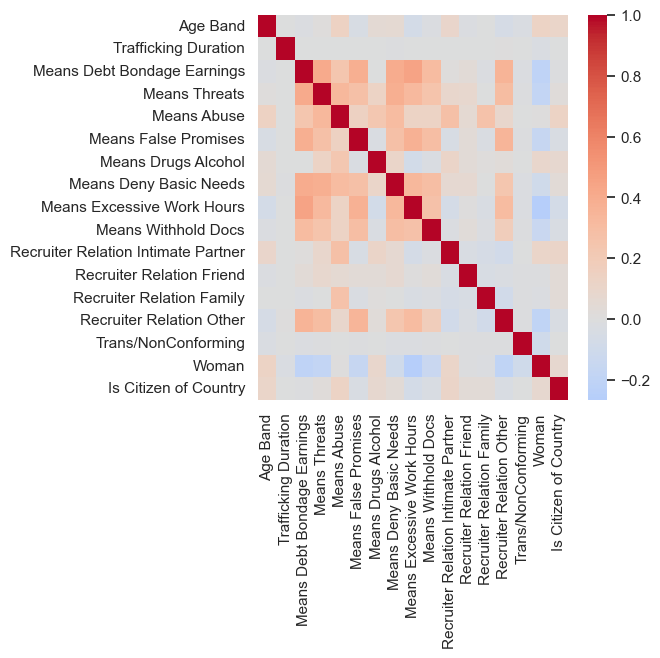

In [133]:
def plot_correlation(df, target_features):
    df = df.select(pl.exclude(target_features)) # remove target features
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(df.to_pandas().corr(), 
                annot=False, 
                cmap='coolwarm', 
                center=0)
    plt.savefig('figures/feature_correlation')
    plt.show()

plot_correlation(df, target_features)

Here, we see some correlation particularly between certain kinds of means of control like debt and documentation withholding. More interesting relationships appear, like a correlation between means of control psychological abuse and recruiter relationship being with a family member. 

Now, I will begin preparing the regression analysis.

First, I will separate the target features in the data from the predictive features (X vs Ys).

Then, I will do an 80/20 split between training and testing data, followed by separating the Ys column into the two distinct categories to be used in their own models. 

Finally, due to the nature of the regression package I am using, an intercept must be added to our feature matrices. 
I save aside feature_names for later utility

In [134]:
Ys = df.select(target_features)
X = df.select(pl.exclude(target_features))
X_train, X_test, y_train, y_test = (
    train_test_split(X.to_pandas(), Ys.to_pandas(), test_size=0.2, random_state=42)
    )

labour_train = y_train['isForcedLabour']
sexual_train = y_train['isSexualExploit']

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
feature_names = X.columns

Next, I will choose an alpha value. This is in order to perform regularization on my coefficients. This will help address multicollinearity issues, and provide natural feature selection to improve the interpretation of our results. Here, we are using Lasso regularization

In [ ]:
def choose_alpha(labour_train, sexual_train, X_train, X_test, y_test):
    auc_rows = []
    candidate_alphas = [0.1, 1.0]
    for a in candidate_alphas:
        print(f"\nEvaluating alpha = {a}...")
        m_labour = Logit(labour_train, X_train).fit_regularized(
            method='l1_cvxopt_cp', alpha=a, maxiter=1000, cnvrg_tol=1e-8, disp=False
        )
        m_sexual = Logit(sexual_train, X_train).fit_regularized(
            method='l1_cvxopt_cp', alpha=a, maxiter=1000, cnvrg_tol=1e-8, disp=False
        )
        auc_labour = roc_auc_score(y_test['isForcedLabour'], m_labour.predict(X_test))
        auc_sexual = roc_auc_score(y_test['isSexualExploit'], m_sexual.predict(X_test))
        auc_rows.append({
            "alpha": a,
            "AUC_forced": auc_labour,
            "AUC_sexual": auc_sexual,
            "AUC_mean": np.mean([auc_labour, auc_sexual]),
        })
    validation_df = pd.DataFrame(auc_rows).sort_values("AUC_mean", ascending=False)
    chosen_alpha = np.max(validation_df.iloc[0]["alpha"])
    print(f"Chosen alpha across models: {chosen_alpha}")
    return chosen_alpha

alpha = choose_alpha(labour_train, sexual_train, X_train, X_test, y_test)


Evaluating alpha = 0.1...


Next, I fit the models:

In [ ]:
model_labour = Logit(labour_train, X_train).fit_regularized(
    method='l1_cvxopt_cp', alpha=alpha, disp=False)

model_sexual = Logit(sexual_train, X_train).fit_regularized(
    method='l1_cvxopt_cp', alpha=alpha, disp=False)

Before investigating our model coefficients, let's see how well they are fitting with AUC-ROC curves. This identifies the rate of true to false positives.

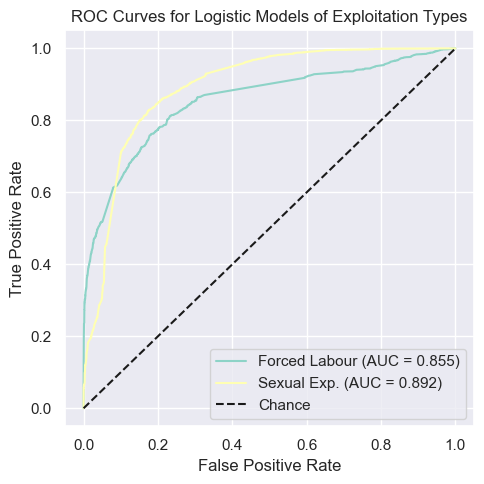

In [ ]:
def plot_roc(models, X, y_trues, title):
    """
    Plot ROC curves for multiple fitted Logit models.
    models  : list of fitted models (e.g. [model_labour, model_sexual])
    X       : feature matrix to evaluate on (e.g. X_test, with constant)
    y_trues : list of true label arrays (same order as models)
    labels  : list of curve labels (for legend)
    """
    plt.figure(figsize=(5, 5))
    for model, y_true, label in zip(models, y_trues, ['Forced Labour', 'Sexual Exp.', 'Other Exp.']):
        y_score = model.predict(X)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_val:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title or 'ROC curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('figures/roc_curves')
    plt.show()
    
plot_roc(
    models=[model_labour, model_sexual],
    X=X_test,
    y_trues=[y_test['isForcedLabour'], y_test['isSexualExploit']],
    title='ROC Curves for Logistic Models of Exploitation Types'
)

The L1‑regularized logistic models showed good discrimination for both outcomes, with AUC‑ROC of 0.86 for forced labour and 0.89 for sexual exploitation, indicating that the models can reliably distinguish exploited from non‑exploited cases across a range of decision thresholds.


## Analysis
Now, we can investigate the model coefficients. This begins by creating the odds ratios (OR), which means taking:

$$\text{OR} = e^{\text{coef}} $$

The OR represents the odds of an outcome happening given a condition is true, compared to the odds of the same outcome if that condition is false.
Here is a function that will extract the coefficients from a logistic model, and exponentiate to see the odds ratios. 

In [ ]:
def get_odds_ratios(model, outcome_label, print):
    """ 
    Extract coefficients from a logistic model, exponentiate to odds ratios,
    and include 95% confidence intervals.
    model: a fitted statsmodels Logit model
    outcome_label: the str label of the outcome variable (not used here yet)
    """
    coef = model.params                 # pandas Series
    conf = model.conf_int()             # pandas DataFrame with columns [0, 1]

    # Exponentiate coefficients and CI bounds to get OR and OR CIs
    or_vals = np.exp(coef)
    ci_lower, ci_upper = (
        np.exp(conf[0]), np.exp(conf[1])
    )
    odds_df = pl.DataFrame({
        "feature": coef.index,
        "odds_ratio": or_vals.values,
        "ci_lower": ci_lower.values,
        "ci_upper": ci_upper.values,
    })
    odds_df = (
        odds_df
        .filter(pl.col("feature") != "const")   # remove intercept
        .filter(pl.col("odds_ratio") != 1.0)    # drop OR=1 (coef=0)
        .with_columns([
            pl.col("odds_ratio").round(2),
            pl.col("ci_lower").round(2),
            pl.col("ci_upper").round(2),
        ])
    )
    if print:
        with pl.Config(tbl_rows=-1):
            print(odds_df)
    return odds_df

# CHANGE print FLAG TO TRUE TO CONFIRM TABLE VALUES
odds_labour = (
    get_odds_ratios(model=model_labour, 
                    outcome_label='Forced labour', 
                    print=False) # to print the table, set = True
    )
odds_sexual = (
    get_odds_ratios(model=model_sexual, 
                    outcome_label='Sexual exploitation', 
                    print=False) # to print the table, set = True
)

The values below were extracted directly from the odds_labour and odds_sexual tables. I did not print them for stylistic reasons when publishing this notebook, but to confirm their accuracy, please change the print=False flag to True.

Breaking down the values into three discussions: demographics, control tactics, and recruiter relationships:

### Labour Exploitation Model Results:

| Demographic Features       | Odds Ratio   | 95% CI       |
|----------------------------|------|--------------|
| Age Band                   | 0.96 | [0.96, 0.97] |
| Trafficking Duration       | .48  | [.25, 0.9]   |
| Is Citizen of Country      | 0.66 | [0.61, 0.71] |
| Gender: Woman              | 0.13 | [0.13, 0.14] |
| Gender: Trans/NonConforming| 0.25 | [0.17, 0.35] |

* Age Band: To refresh, our age bands represent broad categories that victims were binned into (0-8 years old, 24-26, etc). According to the codebook, the ages are associated with when the victim "was assisted/identified/reported". Here, an OR of .96 signifies a 4% lower odds of forced labour with each band increase. There is a small effect, and could likely be do to biases discussed earlier (i.e. more children rescued from labour exploitation than other demographics).

* Trafficking Duration: Here, we see that labour exploitation victims tend to generally experience shorter durations of exploitation before accessing a hotline. 

* is Citizen of Country: Here,  we see that citizens have are around ~34% lower odds of being brought into forced labour. This means there is a higher concentration of victims of labour exploitation who do not have citizenship in their country of exploitation. 

* Gender: Control category was Male. This means our odds ratios for the other genders will be interpreted with respect to the Male cateogry.
    * Woman: This indicates that women are 87% less likely to be experience forced labour exploitation relative to men. The CI is very tight (.01) meaning a large, precisely estimated difference.
    * Trans/NonConforming: Trans/NonConforming victims are 75% less likely to experience forced labour exploitation relative to men. The CI is wider, but there is still significant association.
    * Overall, there is a much higher concentration of the male gender population that fell victim to forced labour exploitation. 

| Control Features            | Odds Ratio    | 95% CI        |
|-----------------------------|-------|---------------|
| Means Debt Bondage Earnings | 3.36  | [3.15, 3.58]  |
| Means Threats               | 1.76  | [1.66, 1.86]  |
| Means Abuse                 | 1.08  | [1.02, 1.15]  |
| Means False Promises        | 2.46  | [2.19, 2.76]  |
| Means Drugs Alcohol         | 0.34  | [0.31, 0.37]  |
| Means Deny Basic Needs      | 1.73  | [1.62, 1.83]  |
| Means Excessive Work Hours  | 10.77 | [9.18, 12.64] |
| Means Withhold Docs         | 1.62  | [1.44, 1.81]  |

* Findings:
    * The means of control most strongly associated with forced labour are excessive work hours, withholding documentation, threats, and false promises. These are not the only tactics used, but they highlight how non‑citizens in the country of exploitation can be made especially vulnerable when immigration status is leveraged against them.

| Relationship Features           | Odds Ratio   | 95% CI       |
|----------------------------------|------|--------------|
| Recruiter Relation Intimate Partner | 0.67 | [0.61, 0.73] |
| Recruiter Relation Friend        | 0.73 | [0.64, 0.83] |
| Recruiter Relation Family        | 0.93 | [0.86, 1.01] |
| Recruiter Relation Other         | 2.61 | [2.44, 2.80] |

* Findings: 
    * Those experiencing forced labour are significantly more likely to have not had a relationship with their recruiter that fits into the other three categories. According to the codebook, "this may include, but is not limited to, labour brokers, contractors, formal employers, or smugglers".


### Sexual Exploitation Model Results:

| Demographic Features        | Odds Ratio    | 95% CI        |
|-----------------------------|-------|---------------|
| Age Band                    | 1.04  | [1.03, 1.05]  |
| Trafficking Duration        | 0.98  | [0.61, 1.60]  |
| Gender: Woman               | 10.67 | [10.14, 11.23]|
| Gender: Trans/NonConforming | 13.30 | [7.22, 24.48] |
| Is Citizen of Country       | 1.91  | [1.74, 2.10]  |


* Age Band: Each step into an older age band is associated with 4% higher odds of sexual exploitation. The tight CI above 1 indicates a small but precise increase.

* Trafficking Duration: The confidence interval is extremely uncertain here. This indicates that duration is not significantly associated with sexual exploitation in this model.

* is Citizen of Country: Victims of sexual exploitation are much more likely to be citizens in their country of exploitation. This means, citizens have about 90% higher odds of sexual exploitation than non-citizens. 

* Gender: 
    * Woman have about 11x higher odds of sexual exploitation compared to men in this dataset. The tight CI indicates a large precise difference. While this is important, it does NOT mean that men do not experience sexual exploitation. 
    * Trans/NonConforming victims have about 13x the odds of sexual exploitation relative to men. 
    * Overall, we can see that men are more likely to be trafficked for labour, and other genders are more likely to be trafficked for sexual exploitation. However, these are not absolutist categories. 

| Control Features            | Odds Ratio   | 95% CI       |
|-----------------------------|------|--------------|
| Means Debt Bondage Earnings | 0.29 | [0.27, 0.32] |
| Means Threats               | 0.60 | [0.57, 0.64] |
| Means Abuse (Phys, Psych)   | 1.17 | [1.10, 1.26] |
| Means False Promises        | 0.62 | [0.55, 0.69] |
| Means Drugs Alcohol         | 8.10 | [7.06, 9.29] |
| Means Deny Basic Needs      | 0.56 | [0.52, 0.59] |
| Means Excessive Work Hours  | 0.12 | [0.11, 0.14] |
| Means Withhold Docs         | 0.63 | [0.56, 0.71] |

* Findings:
    * Victims of sexual exploitation are most likely to be controlled by substance abuse, followed by abuse and threats. This contrasts heavily with the control types we saw in labour exploitation victims, where we see almost inverted effects.



| Recruiter Relationships          | Odds Ratio   | 95% CI       |
|----------------------------------|------|--------------|
| Recruiter Relation Intimate Partner | 1.84 | [1.62, 2.08] |
| Recruiter Relation Friend        | 1.37 | [1.18, 1.59] |
| Recruiter Relation Family        | 1.08 | [0.98, 1.18] |
| Recruiter Relation Other         | 0.37 | [0.34, 0.39] |

* Findings: 
    * In contrast to labour exploitation victims, this group is much more likely to have a relationship with their recruiter that fits into one of the three specific categories including intimate partner, friends, or family. This sheds significant light on the dynamics that setup sexual exploitation. 


Now, I will create a forest plot to visualize how these odds ratios distribute across exploitation types.

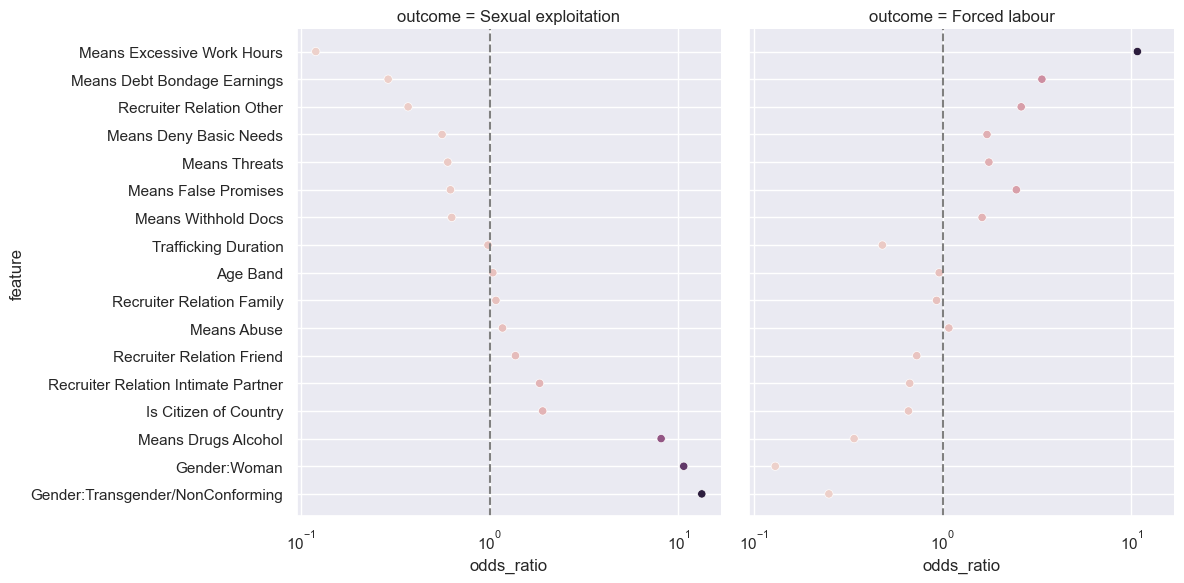

<Figure size 1000x1000 with 0 Axes>

In [ ]:
odds_labour = (
    odds_labour
    .with_columns(
        pl.lit('Forced labour').alias('outcome')
    )
)
odds_sexual = (
    odds_sexual
    .with_columns(
        pl.lit('Sexual exploitation').alias('outcome')
    )
)
odds_all = pl.concat([odds_labour, odds_sexual])

def forest_plot(odds_all):
    odds_all = odds_all.sort(["odds_ratio"])
    g = sns.FacetGrid(
        odds_all,
        col='outcome',      
        sharex=True, sharey=True,
        height=6,
        )
    g.map_dataframe(
        sns.scatterplot,
        x='odds_ratio', 
        y='feature',
        hue='odds_ratio', 
        legend=True
    )
    for ax in g.axes.flatten():
        ax.axvline(1, ls='--', c='grey')
        ax.set_xscale('log')
    plt.tight_layout()
    plt.show()
    g.fig.set_size_inches(10, 10)
    plt.show()
    plt.savefig('figures/forest_plot')

forest_plot(odds_all)

### Final Results
Here, we can visually identify the contrasts in experiences across exploitation types. 
Features at $10^0$ represent no significant difference in odds. Therefore, we can easily identify the features that increase the odds of both exploitation types. Sexual exploitation is most strongly associated with being trans/nonconforming, female, controlled by drugs/alcohol, a citizen in country of exploitation, and a friend or intimate partner relationship with recruiter. 

In contrast, labour exploitation victims almost mirror those of sexual exploitation. Factors that significantly increase odds are excessive work hours, debt bondage earnings, denial of basic needs, withholding documentation, and other recruiter relationships. They are far more likely to identify as male, and have a relatively hgiher concentration of lack of citizenship in the country of exploitation.


### Implications & Limitations:

We saw significant differences in the risk profiles across the two exploitation types. Dominantly gender differences, immigration status, the role of social ties to recruiters, and how means of control differ. However, there are limitations of this analysis. There are likely unmeasured confounders like economic context, migration pathways, policing practices, and service-provider priorities that influence who is exploited and how they are recorded. Moreover, the biases identified at the beginning of this analysis cannot be ignored or eradicated. This dataset is meant to mimic real cases while protecting privacy, patterns are not precise population estimates. 


### Conclusions: 

This project set out to use the CTDC global synthetic dataset to understand which victim characteristics, recruiter relationships, and means of control are most strongly associated with sexual exploitation versus forced labour. Using regularized logistic regression, I found that sexual exploitation is much more likely among women and transgender/non‑conforming victims, citizens, and those controlled with drugs and alcohol or recruited by intimate partners and friends, while forced labour is concentrated among men and non‑citizens who experience work‑ and immigration‑related control tactics such as excessive hours, debt bondage, denial of basic needs, threats, and document withholding, often via “other” recruiter types like brokers or employers. Together, these results highlight that different forms of exploitation operate through distinct but overlapping risk profiles, implying that effective prevention, identification, and support policies must be tailored to specific exploitation types rather than treating “trafficking” as a single homogeneous phenomenon.
